In [38]:
import os, pvl, itertools
from shapely.geometry import Polygon, Point, MultiPolygon
from sklearn.neighbors import KernelDensity
import numpy as np
from plio.io import io_controlnetwork
from plio.io.isis_serial_number import generate_serial_number
import matplotlib.pyplot as plt
import knoten
import pyproj
import csmapi
from pysal.explore.spaghetti.analysis import kfunction

In [2]:
def plot_geometry(geometry, axis=None, **kwargs):
    if geometry.is_empty:
        return
    if geometry.geom_type == 'MultiPolygon':
        for sub_geom in geometry:
            plot_geometry(sub_geom, axis=axis, **kwargs)
    elif geometry.geom_type == 'Polygon':
        plot_geometry(geometry.exterior, axis=axis, **kwargs)
    elif geometry.geom_type == 'GeometryCollection':
        for sub_geom in list(geometry):
            plot_geometry(sub_geom, axis=axis, **kwargs)
    elif hasattr(geometry, "xy"):
        x, y = geometry.xy
        if axis is not None:
            axis.plot(x, y, **kwargs)
        else:
            plt.plot(x, y, **kwargs)
    else:
        print(f"Geometry is of type {geometry.geom_type}")

In [3]:
def generate_random_points(geometry, number=1):
    list_of_points = []
    minx, miny, maxx, maxy = geometry.bounds
    counter = 0
    while counter < number:
        coord = np.random.uniform([minx, maxx], [miny, maxy])
        pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if geometry.contains(pnt):
            list_of_points.append(pnt)
            counter += 1
    return list_of_points

In [4]:
def back_project_geometry(geometry, sensor):
    if geometry.geom_type == 'Polygon':
        lons, lats = geometry.exterior.xy
        semi_major, semi_minor = knoten.csm.get_radii(sensor)
        ecef = pyproj.Proj(proj='geocent', a=semi_major, b=semi_minor)
        lla = pyproj.Proj(proj='latlon', a=semi_major, b=semi_minor)
        image_coords = []
        for lon, lat in zip(lons, lats):
            x, y, z = pyproj.transform(lla, ecef, lon, lat, 0)
            image_pt = sensor.groundToImage(csmapi.EcefCoord(x, y, z))
            image_coords.append([image_pt.line, image_pt.samp])
        return Polygon(image_coords)
    elif geometry.geom_type == 'MultiPolygon':
        return MultiPolygon([back_project_geometry(sub_geom) for sub_geom in geometry])
    elif geometry.geom_type == 'GeometryCollection':
        return MultiPolygon([back_project_geometry(sub_geom) for sub_geom in geometry if sub_geom.geom_type == 'Polygon'])

In [40]:
def compute_distances(points):
    distances = []
    for pt1, pt2 in itertools.combinations(points, 2):
        distance = pt1.distance(pt2)
        distances.append(distance)
        distances.append(distance)
    return np.asarray(distances)

In [5]:
data_dir = '/Users/jmapel/ctx_test_data'
net = 'wTestingGround.net'
cube_list = 'local_cubes.lis'

In [6]:
sensors = knoten.bundle.generate_sensors(os.path.join(data_dir, cube_list), clean=True)

In [7]:
cnet_df = io_controlnetwork.from_isis(os.path.join(data_dir, net))

In [8]:
footprints = {}
for sn, sensor in sensors.items():
    boundary = knoten.csm.generate_boundary([sensor.getImageSize().line, sensor.getImageSize().samp])
    lons, lats, _ = knoten.csm.generate_latlon_boundary(sensor, boundary)
    footprints[sn] = Polygon([[lon, lat] for lon, lat in zip(lons, lats)])

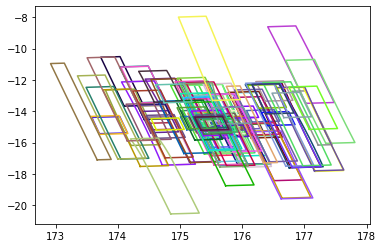

In [9]:
image_colors = {}
for sn, footprint in footprints.items():
    image_colors[sn] = np.random.rand(3,)
    plot_geometry(footprint, c=image_colors[sn])

In [10]:
overlapping = {}
for sn in footprints.keys():
    overlapping[sn] = Polygon()
for sn1, sn2 in itertools.combinations(footprints.keys(), 2):
    intersection = footprints[sn1].intersection(footprints[sn2])
    if (intersection):
        overlapping[sn1] = overlapping[sn1].union(intersection)
        overlapping[sn2] = overlapping[sn2].union(intersection)
for sn, overlap in overlapping.items():
    overlapping[sn] = overlap.simplify(0.01)

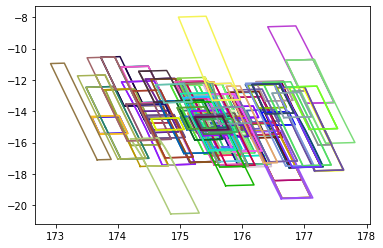

In [11]:
for sn, overlap in overlapping.items():
    plot_geometry(footprints[sn], c=image_colors[sn])
    plot_geometry(overlap, c=image_colors[sn])

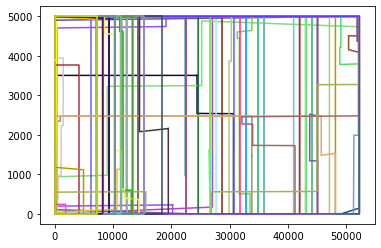

In [12]:
for sn, overlap in overlapping.items():
    plot_geometry(back_project_geometry(overlap, sensors[sn]), c=image_colors[sn])

In [57]:
image_k = {}
image_k_envelope = {}
num_reps = 100
k_func_steps = 100
for sn, overlap in overlapping.items():
    print(f"On image {sn}")
    image_geom = back_project_geometry(overlap, sensors[sn])
    if image_geom.area <= 1e-10:
        print(f"  Skipping {sn} for having too little area")
        continue
    min_line, min_samp, max_line, max_samp = image_geom.bounds
    max_distance = np.sqrt((max_line - min_line)**2 + (max_samp - min_samp)**2)
    upper = np.zeros(steps)
    lower = np.ones(steps) * max_distance * max_distance * max_distance
    count = 0
    measure_points = [Point(measure[0], measure[1]) for measure in cnet_df.loc[cnet_df.serialnumber == sn, ["line", "sample"]].values]
    if not measure_points:
        print(f"  Skipping {sn} for having no measures")
        continue
    measure_distances = compute_distances(measure_points)
    measure_intensity = len(measure_points) / image_geom.area
    image_k[sn] = kfunction(measure_distances, max_distance, measure_intensity, k_func_steps)
    while count < num_reps:
        count += 1
        points = generate_random_points(image_geom, len(measure_points))
        distances = compute_distances(points)
        sim_k = kfunction(distances, max_distance, measure_intensity, k_func_steps)
        upper = np.maximum(upper, sim_k[1])
        lower = np.minimum(lower, sim_k[1])
    image_k_envelope[sn] = (upper, lower)

On image MRO/CTX/0905024445:239
On image MRO/CTX/0906444978:206
On image MRO/CTX/0907865505:228
On image MRO/CTX/0916476567:009
On image MRO/CTX/0918873281:179
On image MRO/CTX/0924555400:216
On image MRO/CTX/0929348844:241
On image MRO/CTX/0932189959:035
On image MRO/CTX/0933166158:064
On image MRO/CTX/0934586648:221
On image MRO/CTX/0946926628:140
On image MRO/CTX/0950299477:228
On image MRO/CTX/0950743762:213
On image MRO/CTX/0951275588:225
On image MRO/CTX/0953584868:021
On image MRO/CTX/0954561103:166
On image MRO/CTX/1024604499:112
On image MRO/CTX/1027445185:174
On image MRO/CTX/1036500098:181
On image MRO/CTX/1048928677:225
On image MRO/CTX/1056563488:018
On image MRO/CTX/1062333521:234
On image MRO/CTX/1062777900:051
On image MRO/CTX/1066150891:187
On image MRO/CTX/1068015737:224
On image MRO/CTX/1072809473:195
On image MRO/CTX/1073253839:012
On image MRO/CTX/1075206371:161
On image MRO/CTX/1075650719:035
On image MRO/CTX/1076626941:039
On image MRO/CTX/1077603135:227
On image

In [73]:
dense = []
sparse = []
for sn, k_func in image_k.items():
    upper, lower = image_k_envelope[sn]
    diff = upper - lower
    above = (k_func[1] - upper) / diff
    below = (lower - k_func[1]) / diff
    if any(above > 1):
        dense.append(sn)
    if any(below > 1):
        sparse.append(sn)

In [74]:
print("Dense images:", dense)
print("Sparse images:", sparse)

Dense images: ['MRO/CTX/0906444978:206', 'MRO/CTX/0907865505:228', 'MRO/CTX/0918873281:179', 'MRO/CTX/0924555400:216', 'MRO/CTX/0929348844:241', 'MRO/CTX/0932189959:035', 'MRO/CTX/0934586648:221', 'MRO/CTX/0950743762:213', 'MRO/CTX/1027445185:174', 'MRO/CTX/1036500098:181', 'MRO/CTX/1048928677:225', 'MRO/CTX/1056563488:018', 'MRO/CTX/1066150891:187', 'MRO/CTX/1068015737:224', 'MRO/CTX/1072809473:195', 'MRO/CTX/1073253839:012', 'MRO/CTX/1075206371:161', 'MRO/CTX/1075650719:035', 'MRO/CTX/1076626941:039', 'MRO/CTX/1078047447:250', 'MRO/CTX/1080444090:051', 'MRO/CTX/1081420218:137', 'MRO/CTX/1081864496:232', 'MRO/CTX/1082308792:252', 'MRO/CTX/1084705454:215', 'MRO/CTX/1085681760:197', 'MRO/CTX/1086570520:232', 'MRO/CTX/1089499243:211', 'MRO/CTX/1091364033:216', 'MRO/CTX/1092340153:139', 'MRO/CTX/1092784442:205', 'MRO/CTX/1102105786:235', 'MRO/CTX/1107343381:198', 'MRO/CTX/1109295812:238', 'MRO/CTX/1116398369:016', 'MRO/CTX/1124565165:220', 'MRO/CTX/1132643724:102', 'MRO/CTX/1133619815:201

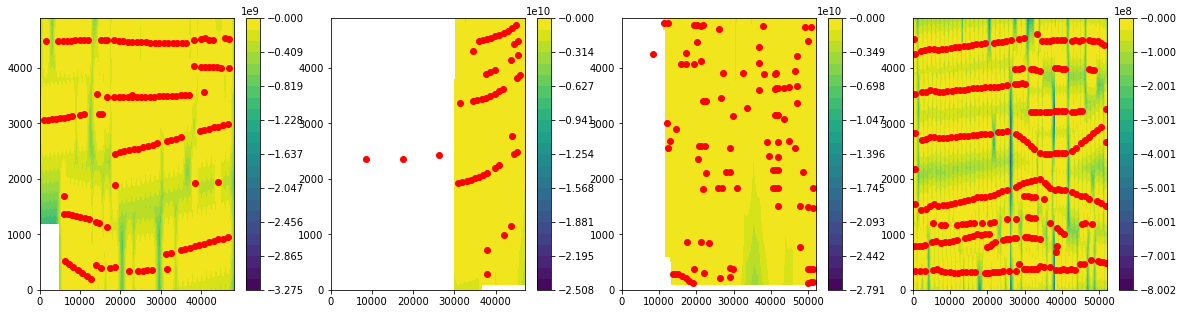

In [81]:
downsample = 100
fig, axis_list = plt.subplots(1, 4, figsize=(20,5))
axis_index = 0
for sn in sparse:
    sensor = sensors[sn]
    num_lines = sensor.getImageSize().line 
    num_samples = sensor.getImageSize().samp
    measure_data = cnet_df.loc[cnet_df.serialnumber == sn, ["line", "sample"]].values
    kde = KernelDensity(kernel="gaussian", bandwidth=0.04)
    kde.fit(measure_data)
    lines, samples = np.meshgrid(np.arange(0, num_lines, downsample), np.arange(0, num_samples, downsample))
    sample_coords = np.vstack([lines.ravel(), samples.ravel()]).T
    scores = kde.score_samples(sample_coords)
    scores = scores.reshape(lines.shape)
    image_geom = back_project_geometry(overlapping[sn], sensor)
    mask = np.array([not image_geom.contains(Point(line, samp)) for line, samp in zip(lines.ravel(), samples.ravel())])
    mask = mask.reshape(lines.shape)
    masked_lines = np.ma.masked_array(lines, mask=mask)
    masked_samples = np.ma.masked_array(samples, mask=mask)
    masked_scores = np.ma.masked_array(scores, mask=mask)
    levels = np.linspace(scores.min(), scores.max(), 25)
    density_plot = axis_list[axis_index].contourf(masked_lines, masked_samples, masked_scores, levels=levels)
    axis_list[axis_index].plot(measure_data[:,0], measure_data[:,1], 'ro')
    fig.colorbar(density_plot, ax=axis_list[axis_index])
    axis_index += 1